In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

In [6]:
#load CSV files
measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")
stations_df = pd.read_csv("Resources/hawaii_stations.csv")

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [16]:
# saving references to each respective table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


Date one year before: 2016-08-22 18:00:00


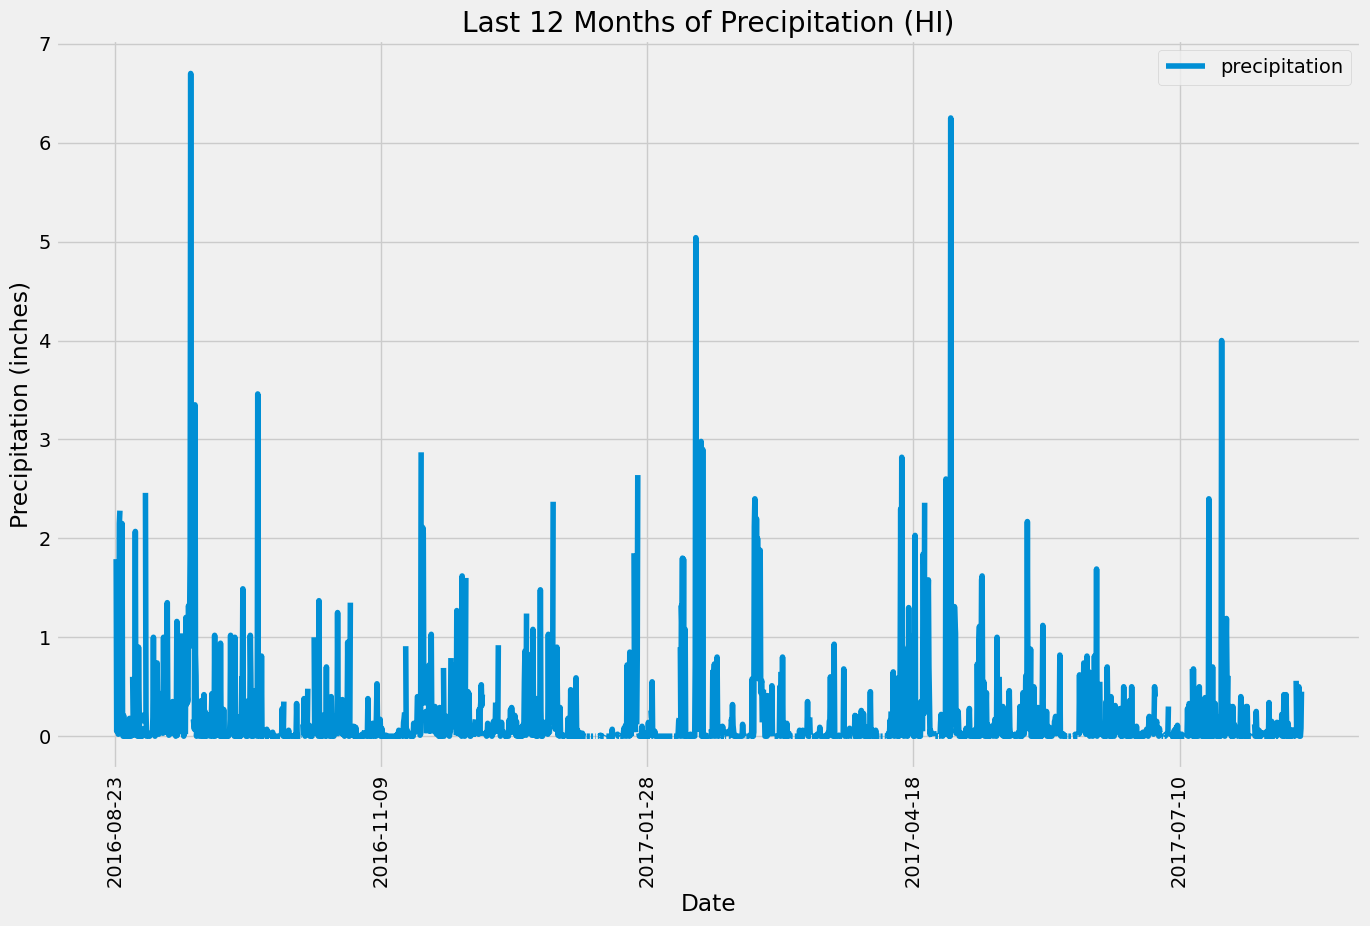

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365.25)
# Calculate the date one year from the last date in data set.
print(f"Date one year before: {one_year_ago}")
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df.set_index("date", inplace=True)
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(15, 9), title="Last 12 Months of Precipitation (HI)", legend=True)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.show()


In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df.describe()
print(precipitation_summary)

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
#return each station on it's own line, as per example result
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = (
    session.query(Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()[0]
)

#calculation of the lowest, highest, and average temperature for the most active station

temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

print(f"Temperature stats for station {most_active_station}: {temp_stats}")

Temperature stats for station USC00519281: [(54.0, 85.0, 71.66378066378067)]


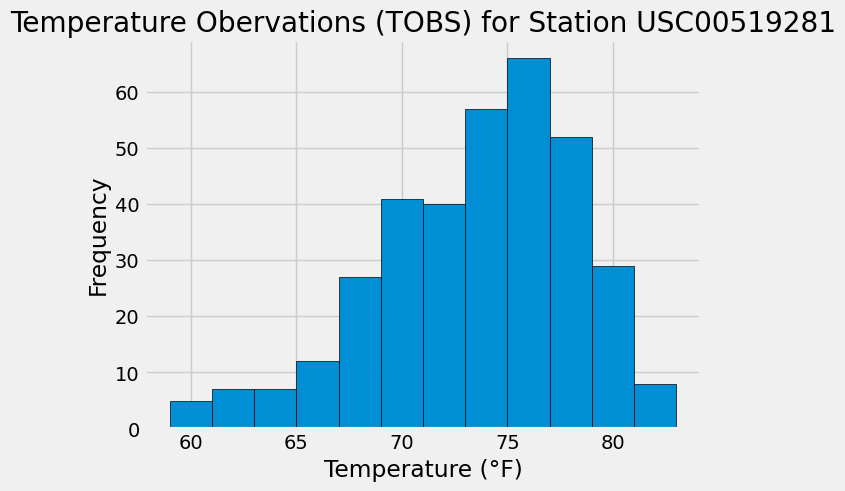

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

#calculation of the date one year ago from the most recent date

one_year_ago = most_recent_date - dt.timedelta(days=365)

#query for prior year of TOBS data for the most active stations
most_active_station = (
    session.query(Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()[0]
)

tobs_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

#take TOBS and create list

tobs_list = [temp[0] for temp in tobs_data]

#plot results (creation of a histogram)

plt.hist(tobs_list, bins=12, edgecolor="black")
plt.title(f"Temperature Obervations (TOBS) for Station {most_active_station}")
plt.xlabel("Temperature (Â°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [40]:
# Close Session
session.close()